In [2]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [3]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')



# Data loading

### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [5]:
# Regulatory Potentials
fn_rag = join(DATADIR,'tracks/TSS_RAG_H3K27ac_RP_3K.csv')
fn_tlx = join(DATADIR,'tracks/TSS_TLX3_H3K27ac_RP_3K.csv')

tlx_27ac = pd.read_csv(fn_tlx, index_col=0)
rag_27ac = pd.read_csv(fn_rag, index_col=0)

tlx_27ac.rename(columns={'potential':'RP_tlx'}, inplace=True)
rag_27ac.rename(columns={'potential':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

tlx_rag_27ac.drop_duplicates(subset='name', inplace=True)

tlx_rag_27ac = tlx_rag_27ac[(tlx_rag_27ac['RP_rag']>0) | (tlx_rag_27ac['RP_tlx']>0)]


Ap,Bp = 'RP_tlx','RP_rag'
cols = ['name', Ap, Bp]

rp_3K = tlx_rag_27ac[cols]

rp_3K = rp_3K.set_index(keys=rp_3K.columns[0])

rp_3K = rp_3K.apply(pd.to_numeric)

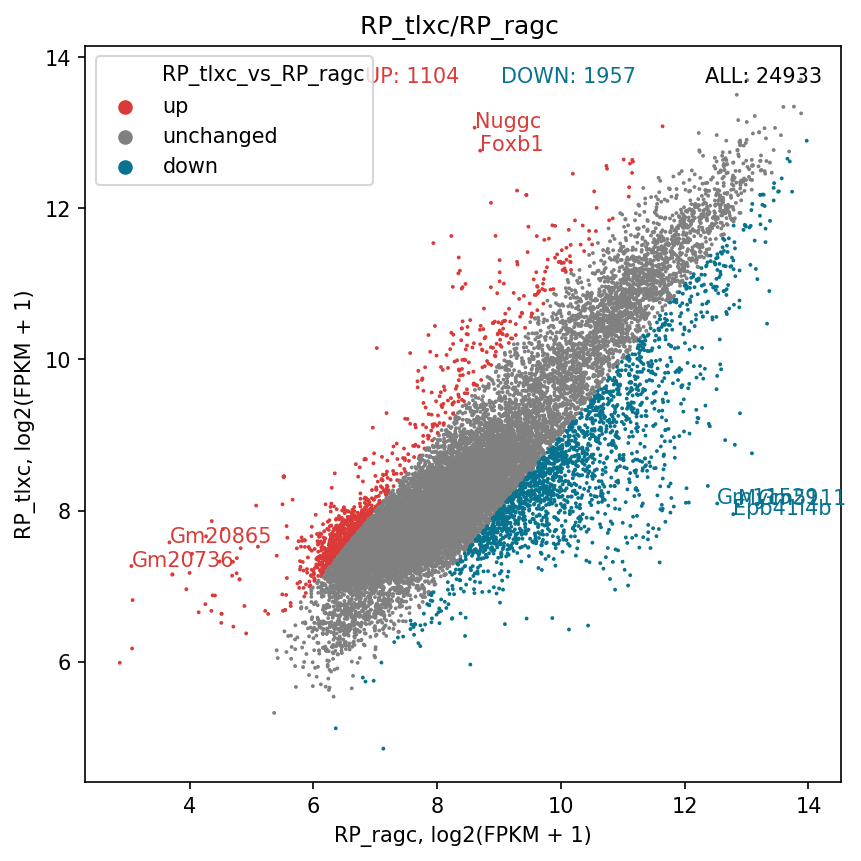

In [6]:
# classes
Ac = Ap+'c'
Bc = Bp+'c'
classe = [Ap+'c', Bp+'c']

up, dn, ax = rn.scatter_n(rp_3K, Ac, Bc, 
                    classes=classe, 
                    n_top=4)

### RNA-expression table TLX3-vs-RAG

In [7]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

# TLX3: Story  - ZERO: 
# UP_RP(TLX3vsRAG)-->UP_Express(TLX3vsRAG)

![title](im/Prom_Story0.png)

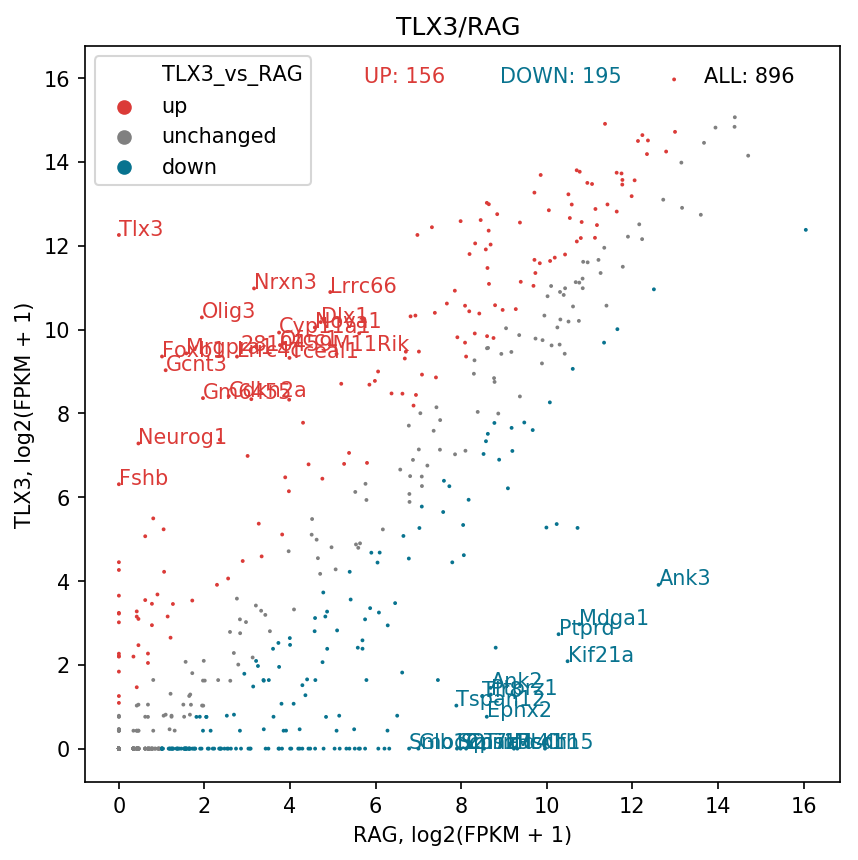

In [8]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

gl_up = list(up.index)

tmp=rn.scatter_n(expr[expr.index.isin(gl_up)], A, B,classes=classes, n_top=18)

### Enrichment

In [9]:
## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'MSigDB_Computational',
       'MSigDB_Oncogenic_Signatures',
       'NCI-60_Cancer_Cell_Lines',
       'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
       ]

In [10]:
## Two analysis possible

#up_genes = gl_up # genes with UP H3K27ac TLX3-vs-RAG 

up_genes = list(tmp[0].index) # ONLY UPregulated genes from genes with UP H3K27ac TLX3-vs-RAG 

UP_genes = [x.upper() for x in up_genes]

enr = erl.enrich_gs(UP_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 1008
GO_Cellular_Component_2018 96
GO_Molecular_Function_2018 195
KEGG_2016 116
Reactome_2016 347
Cancer_Cell_Line_Encyclopedia 614
MSigDB_Computational 296
MSigDB_Oncogenic_Signatures 146
NCI-60_Cancer_Cell_Lines 76
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 1228


In [11]:
# Make additional calculation on existing columns for visualization
#enr.loc[:,'ass_genes_percnt'] = 100*enr.loc[:,'num_list']/enr.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[(enr['p-Val']<0.05)] #&(enr['ass_genes_percnt']>8)

In [12]:
#3= Make claster by kappa coeff
enr_a = erl.cluster(set(UP_genes), enr_a)

In [13]:
#3-1= Filter top clusters
top_clusters = 20
enr_a = enr_a[enr_a['cluster']<top_clusters]

In [34]:
#4= Make clustered geneset 
gs_clust,nt_cl = erl.cluster_genset(enr_a)

In [35]:
#5= Enrich clustered geneset
enr_clust = erl.enrich(UP_genes,gs_clust)

In [36]:
# deduplicate index TODO!!! in package
nt_cl = nt_cl.loc[~nt_cl.index.duplicated(keep='first')]

In [39]:
#6= Add cluster to table
enr_clust = pd.concat([enr_clust,nt_cl.loc[enr_clust.index]['cluster']],axis=1, sort=False)

In [41]:
#7= Make graphs
G_gs = erl.make_graph_n(UP_genes,enr_a, kappa=0.4)
G_cl = erl.make_graph_n(UP_genes,enr_clust, kappa=0.01)

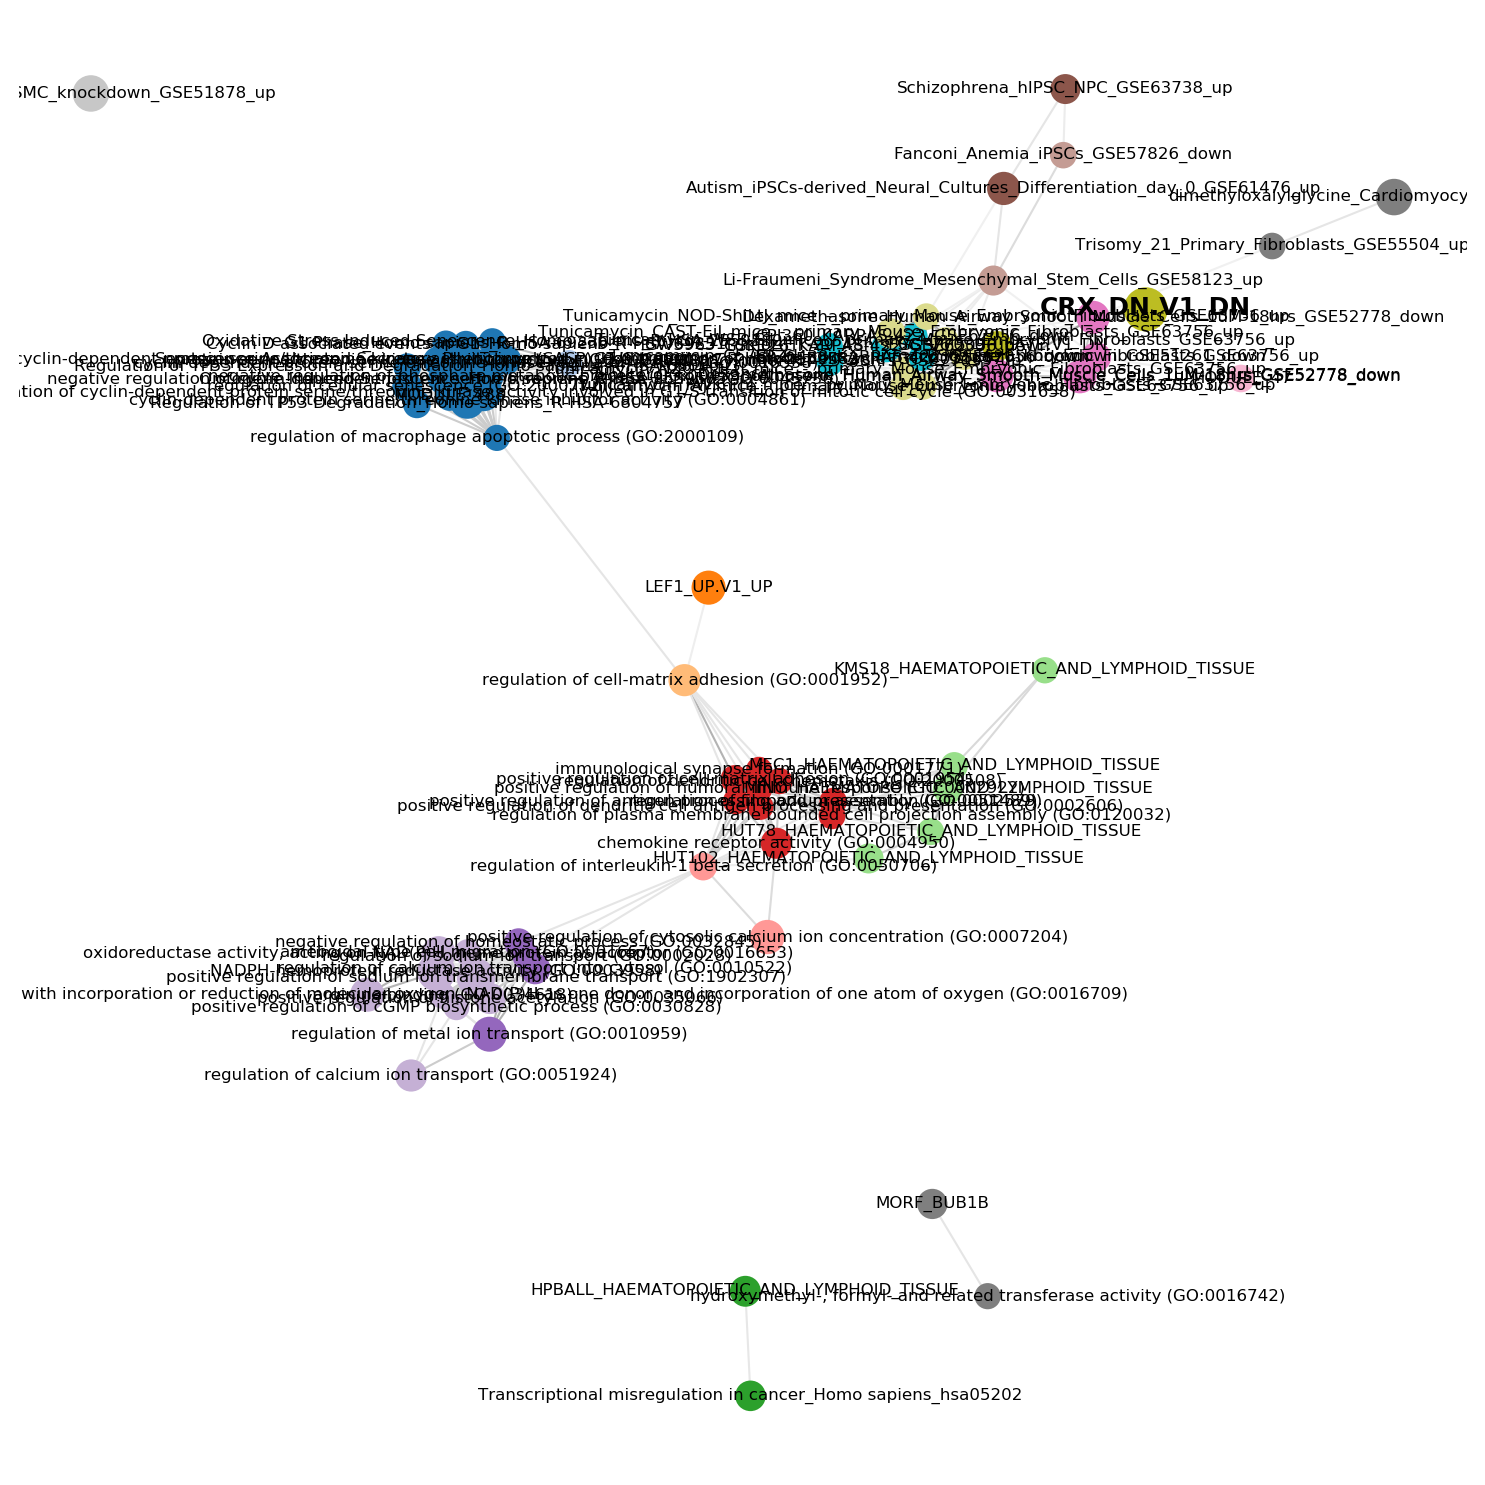

In [42]:
#8= Draw graphs
erl.draw_graph(G_gs, spring=150)

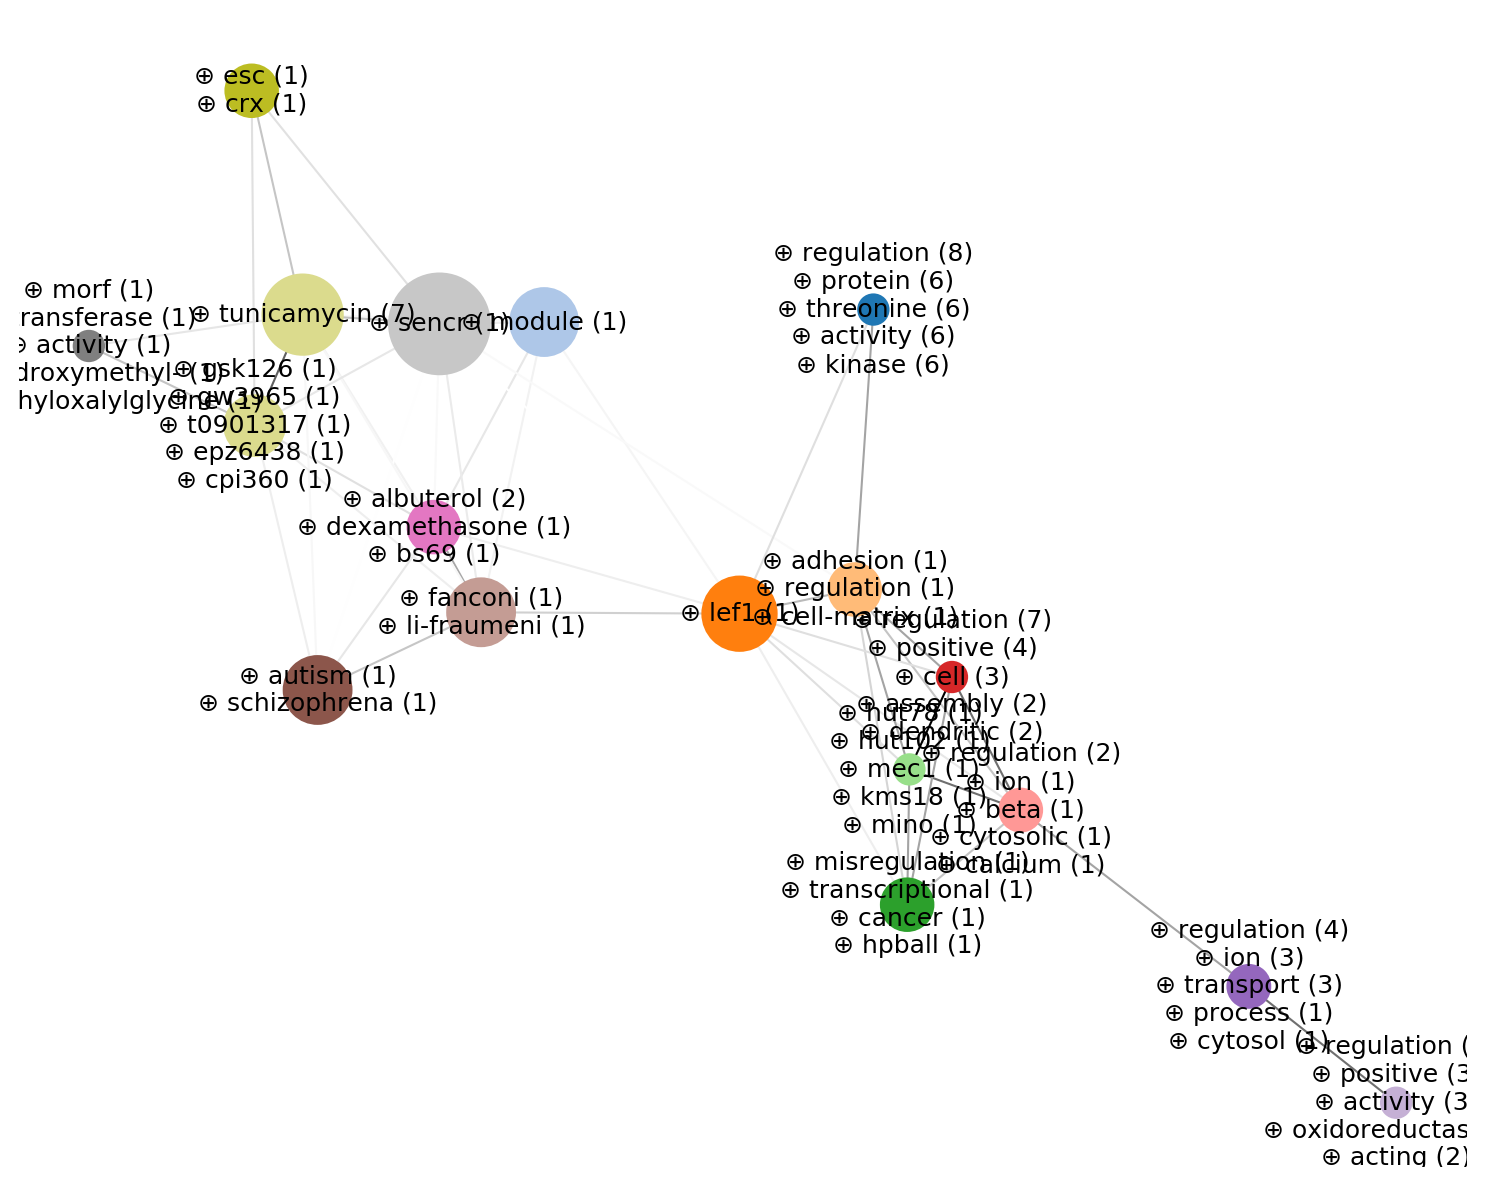

In [45]:
erl.draw_direct(G_cl)

Text(0.5,1,'UP genes regulated UP H3K27ac (TLX3/RAG) ')

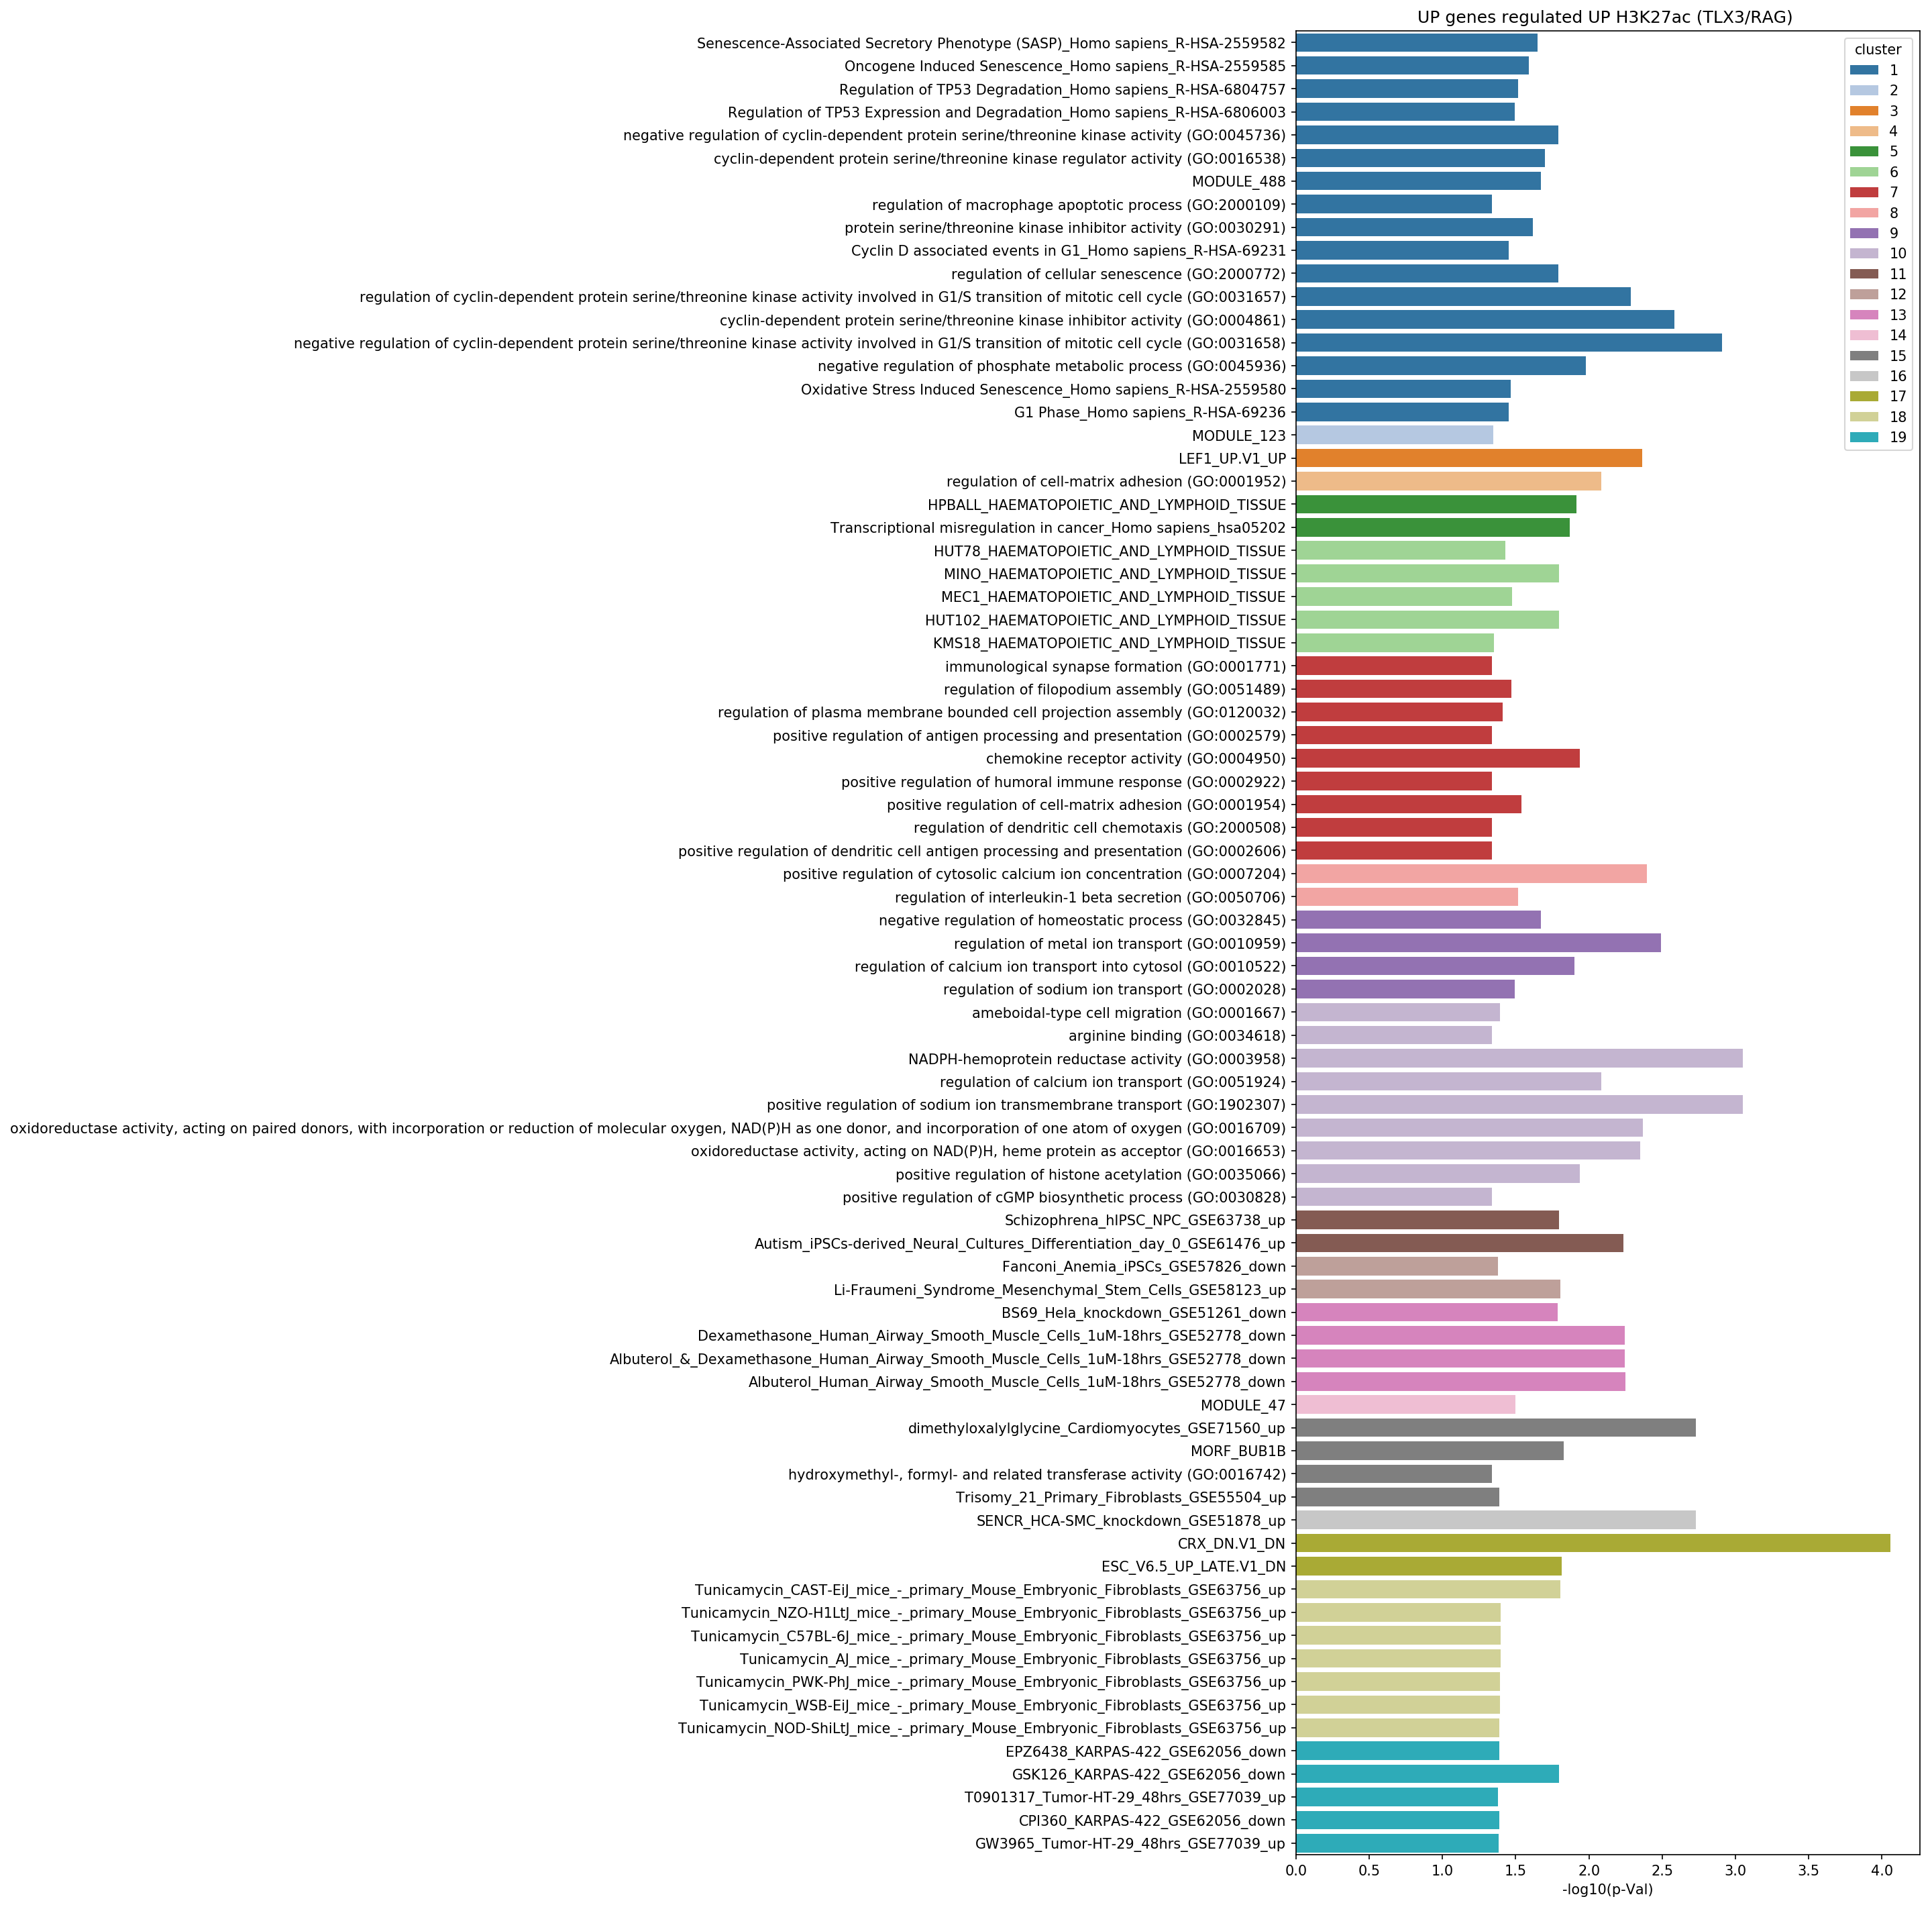

In [52]:
#9= Draw barplot for clustered terms
enr_a.sort_values('cluster', axis=0, inplace = True)

cm = ('tab20' if max(enr_a['cluster'])>10  else 'tab10')

f, ax = plt.subplots(figsize=(8, 24))
sns.barplot(y=enr_a.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = enr_a,
            palette = cm)
ax.set_title('UP genes regulated UP H3K27ac (TLX3/RAG) ')
#plt.tight_layout()

# TLX3: Story ONE -- TLX3 peaks

![title](im/Prom_Story1.png)

In [53]:
## Load TLX peaks file

tlx_peak = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_peak = tlx_peak.slop(b=sl, genome='mm9')

In [ ]:
tlx_rag_27ac.head()

In [54]:
### == UP analysis
tss =  3000
colm9 = ['chrom','start','end', 'name']
up_rp =tlx_rag_27ac.loc[tlx_rag_27ac['name'].isin(list(up_genes))]
#up_rp = up_rp[up_rp['end_mm9']-up_rp['start_mm9']>0]
up_rp = pb.BedTool.from_dataframe(up_rp[colm9])
up_rp = up_rp.slop(b=tss, genome='mm9')


up_rp_tlx = up_rp+tlx_peak
up_rp_gene = up_rp_tlx.to_dataframe()

upTLX_list =list(up_rp_gene['name'])
upTLX_list.sort()

In [55]:
print('Genes with UP RP and upregulated:\n',list(up_genes))
print(':===================================================================:')
print('Genes with UP RP and upregulated and TLX3 peaks:\n',list(upTLX_list))

Genes with UP RP and upregulated:
 ['Tlx3', 'Olig3', 'Foxb1', 'Gcnt3', 'Mrgpra1', 'Nrxn3', 'Neurog1', '2810459M11Rik', 'Lrrc4c', 'Gm6455', 'Fshb', 'Cyp11a1', 'Lrrc66', 'Ofcc1', 'Cdkn2a', 'Nova1', 'Dlx1', 'Tceal1', 'Fos', 'A430093F15Rik', 'Pdlim4', 'Nmnat2', 'Il24', 'Cd69', 'Gpc5', 'Slitrk3', 'Serpinb9c', 'P2rx7', 'Actr3b', 'Dusp4', 'Rapsn', 'Fam71b', 'Iqcf5', 'Ambn', 'Tnfsf8', 'D930028M14Rik', 'Lyl1', 'Tln2', 'Rab19', 'Ly6c2', 'Hbb-y', 'Id3', 'Cysltr1', 'Adam19', '4932438H23Rik', 'Bco2', 'Olfr1509', 'Egr1', 'Ccr7', 'Pmaip1', 'Serpinb9f', 'Serpinb9e', 'Camk2b', '4930524N10Rik', 'Chd7', 'Cenpw', 'Lif', '4922502D21Rik', 'Itgb3', 'Vim', 'Metrnl', 'Gpr17', 'Pik3c2g', 'Capza3', 'Tspan32', 'Piwil2', 'Glrx', 'Gpr82', 'Sorcs3', 'St18', '2200002J24Rik', 'Myo1e', 'Gm6460', '4933402N22Rik', 'Ankrd37', 'Gm11992', 'Ddx3y', 'Nanos1', 'H2-Q2', 'Sfrp2', 'Gfod1', 'Shmt2', 'Eif2s3y', 'Ppp1r16b', 'Tceal3', 'Dbx1', 'Prr5', '4930550C17Rik', 'Rims1', 'Cntn4', 'Gm5861', 'Chac1', 'Gars', 'Kdm5d', 'Rftn1', 'Cam

# TLX3: Story TWO -- TLX3 mutations

![title](im/Prom_Story2.png)

In [56]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

tss =  2000
## TSS of active promoters
up_prom = tlx_rag_27ac.loc[tlx_rag_27ac['name'].isin(list(gl_up))]
#up_prom = up_prom[up_prom['end_mm9']-up_prom['start_mm9']==1]
up_promB = pb.BedTool.from_dataframe(up_prom[colm9])
up_promB = up_promB.slop(b=tss, genome='mm9')


In [57]:
# Count variants in promoters

prom_mut_counts = emm.variants_bed_counts(tlx_gn,up_promB)
prom_mut_counts = prom_mut_counts.to_dataframe()
prom_mut_counts_srt = prom_mut_counts.sort_values('score', ascending=False)

#prom_mut_counts.head(20)

In [58]:
up_prom['mut_score'] = prom_mut_counts['score'].values

In [ ]:
#up_prom.head(20)

In [ ]:
#cpp = {'up':(0.86, 0.23, 0.22), 'unchanged':(0.5,0.5,0.5),'down':(0.03, 0.45, 0.56)}

# f1, ax1 = plt.subplots(figsize=(6.5, 6.5))
# sns.scatterplot(x = 'lgFC_TLXvsRAG', 
#                     y = 'mut_score', 
#                     #hue=diff, 
#                     data=up_prom, 
#                     ax=ax1, 
#  #                   palette=cpp, 
#                     linewidth=0, 
#                     s=3.4)
# ax1.set_title('Genes for UP promoters with high mutation rate')

Text(0.5,1,'Genes for UP promoters with high mutation rate')

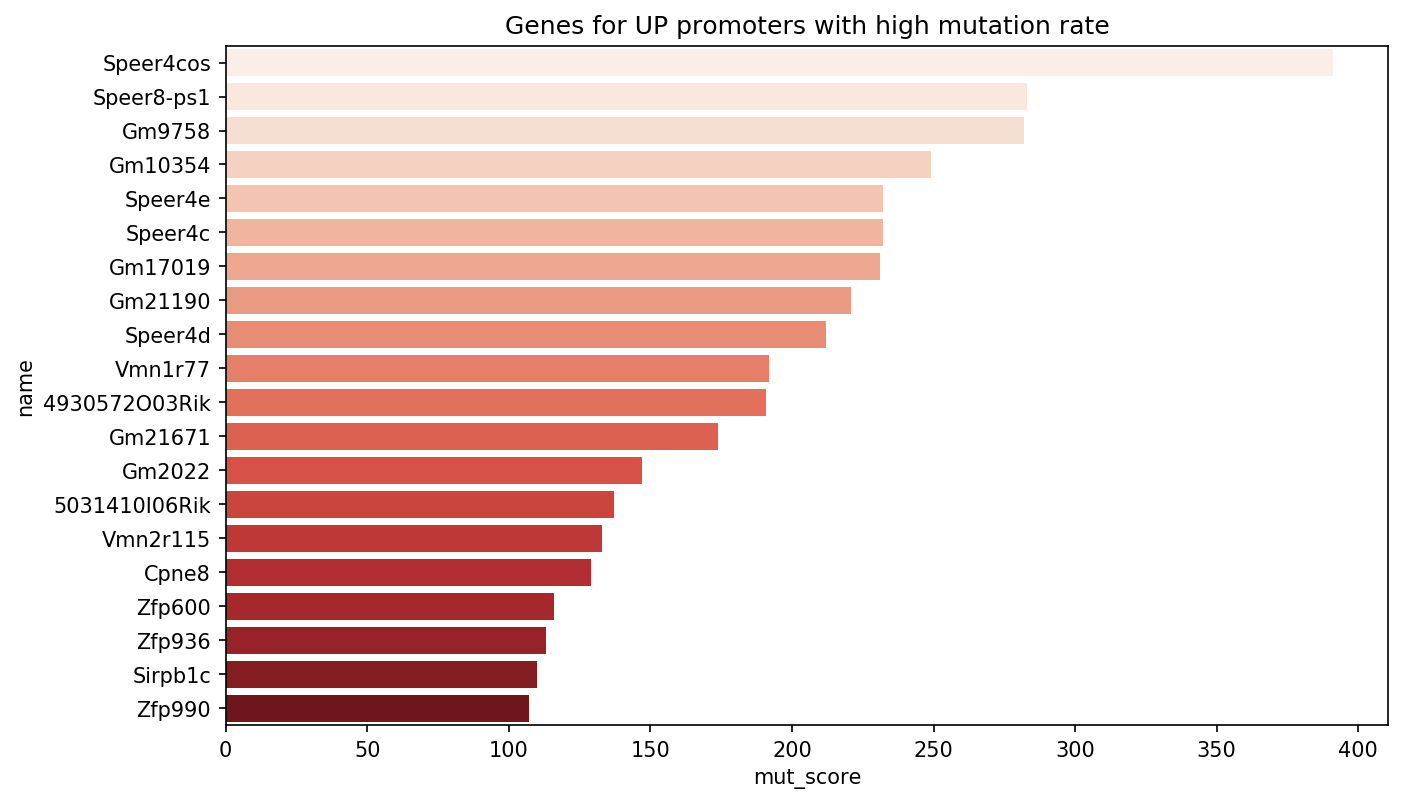

In [59]:
up_mut_rp = up_prom.sort_values('mut_score', ascending=False).head(20)#.sort_values('lgFC_TLXvsRAG', ascending=False)

cm = 'Reds'
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y='name',
            x='mut_score',
            ax = ax, 
            #hue ='lgFC_TLXvsRAG',
            dodge=False,
            data = up_mut_rp ,
            palette = cm)
ax.set_title('Genes for UP promoters with high mutation rate')

# Motifs around mutations in active promoters

In [60]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']

In [61]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [62]:
# Variant inside active promoters
prom_mut_tlx = emm.bed_variants(tlx_gn,up_promB)
print('Variants from TLX3 WGS in active promoters = ', len(prom_mut_tlx))


# Save only if new analysis done
prom_mut_tlx.saveas(join(WGS,'Promoter_Active_TLX3_mut.vcf'))

# Load as table
import allel
prom_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Promoter_Active_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

Variants from TLX3 WGS in active promoters =  8777


In [ ]:
# mut_tb = prom_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Promoter_Motifs_scores.csv'))

In [63]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Promoter_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [64]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [65]:
mut_tb_fltr_srt.head(10)

,CHROM,POS,REF,ALT_1,is_snp,REF_Prot,REF_model,REF_score_ref,REF_score_alt,ALT_Prot,ALT_model,ALT_score_ref,ALT_score_alt,REF_score_diff
1657,chr15,90817555,A,T,True,Sox6,D00039.001,25.139874,0.360045,Foxg1,D00062.001,3.070565,4.166578,24.779829
6863,chr6,129272523,A,C,True,Sox6,D00039.001,21.550243,0.660695,Nkx2-9,D00066.001,1.070347,1.089167,20.889548
4128,chr5,14939106,G,C,True,Znf740,D00083.001,21.905510,1.496824,Sp1,D00017.001,0.467776,10.862597,20.408686
8013,chr7,110623891,A,G,True,Sox6,D00039.001,20.134907,0.016255,Rhox11,D00620.003,1.394890,1.819120,20.118652
2307,chr17,39782041,GCCC,G,False,Znf740,D00083.001,17.526506,0.529407,Zfp202,D00047.001,7.121753,3.853509,16.997099
7880,chr7,93737554,A,C,True,Nr5a2,D00069.001,17.017618,0.093526,Dlx2,D00334.002,0.091085,0.773232,16.924092
2779,chr2,111463296,C,T,True,Sox6,D00039.001,18.021816,1.475031,Pit1,D00034.001,0.332953,6.384589,16.546785
2386,chr17,45867464,C,T,True,Znf740,D00083.001,20.923056,4.379848,Zfp202,D00047.001,8.180673,6.445342,16.543208
3542,chr4,145281948,A,G,True,Sox6,D00039.001,18.449884,3.345334,Foxc2,D00061.001,4.334518,3.496536,15.104550
7646,chr7,50436792,T,G,True,Sox6,D00039.001,15.633462,0.597205,Ahctf1,D00053.001,2.383504,1.017403,15.036257


## Find promoters with TFS changes and associated genes

In [66]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()


In [67]:
#len(up_promB)

In [68]:
mut_tf_prom = up_promB.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_prom.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_prom.rename(columns={'thickEnd':'protein'}, inplace=True)

In [69]:
mut_tf_prom_dd = mut_tf_prom.drop_duplicates()

In [70]:
print('Genes with promoters with TFBS cahnges:\n', list(mut_tf_prom_dd['name'].unique()))

Genes with promoters with TFBS cahnges:
 ['St18', 'Sntg1', 'Mir206', 'Il1rl1', '4930448I06Rik', 'Gulp1', '4930521E06Rik', 'Dnah7b', 'Slc39a10', 'Cps1', 'Gm7609', 'Gm4788', 'Fmo6', 'Rsph4a', 'Bves', 'Slc5a8', 'Gm31592', 'Acss3', '4930503E24Rik', '4930484H19Rik', 'Shmt2', 'Olfr771', 'Olfr776', 'Olfr784', 'Olfr789', 'Olfr790', 'Olfr806', 'Olfr825', 'Gm11992', '4930554G24Rik', '1700046C09Rik', 'Pom121l12', 'Mir216a', 'Tlx3', 'Gm12128', 'Gabra6', 'Fam71b', 'Timd4', 'Sgcd', 'Olfr1385', 'Nmur2', 'Ncoa1', '9030624G23Rik', 'Slirp', 'Gm2016', 'Gm2022', 'Gm2042', 'Gm6803', 'Gm21319', 'Gm10436', 'Gm5662', 'Lgmn', 'Prl2c2', 'Prl2c5', 'Serpinb9c', 'Slc35b3', 'Slc34a1', '4930550C17Rik', 'Neurog1', 'Olfr466', 'Gm20554', 'Glrx', 'Ankrd55', '4930521O11Rik', 'Gm5087', 'Olfr1509', 'Acot10', 'Cdh12', 'Gm10373', 'Kcnv1', 'Ly6c2', 'Cpne8', 'Kif21a', 'Gm26760', 'D630010B17Rik', 'Fmnl3', 'Igfbp6', 'Camk2n2', 'Atp13a5', 'Gm10512', 'Tcp10c', 'Vmn2r91', 'Vmn2r102', 'Vmn2r108', 'Vmn2r109', 'Vmn2r114', 'Vmn2r115', 

In [71]:
genes_mut_tf_prom = [x.upper() for x in list(mut_tf_prom_dd['name'].unique())]

enr_genes_mut_tf_prom = erl.enrich_gs(genes_mut_tf_prom,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 593
GO_Cellular_Component_2018 77
GO_Molecular_Function_2018 174
KEGG_2016 61
Reactome_2016 284
Cancer_Cell_Line_Encyclopedia 559
MSigDB_Computational 250
MSigDB_Oncogenic_Signatures 119
NCI-60_Cancer_Cell_Lines 58
RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO 1098


In [72]:
# Make additional calculation on existing columns for visualization
#enr_genes_mut_tf_prom.loc[:,'ass_genes_percnt'] = 100*enr_genes_mut_tf_prom.loc[:,'num_list']/enr_genes_mut_tf_prom.loc[:,'num_term']


# For futher analysis it is convinient to filter terms by p-value
enr_genes_mut_tf_prom = enr_genes_mut_tf_prom[(enr_genes_mut_tf_prom['p-Val']<0.05)]
# &(enr_genes_mut_tf_prom['ass_genes_percnt']>5)

## Cluster: this calculate and add cluster number column
#enr_genes_mut_tf_enh = erl.cluster(genes_mut_tf_enh,enr_genes_mut_tf_enh)
enr_genes_mut_tf_prom =erl.cluster(set(genes_mut_tf_prom), 
                                                 enr_genes_mut_tf_prom)




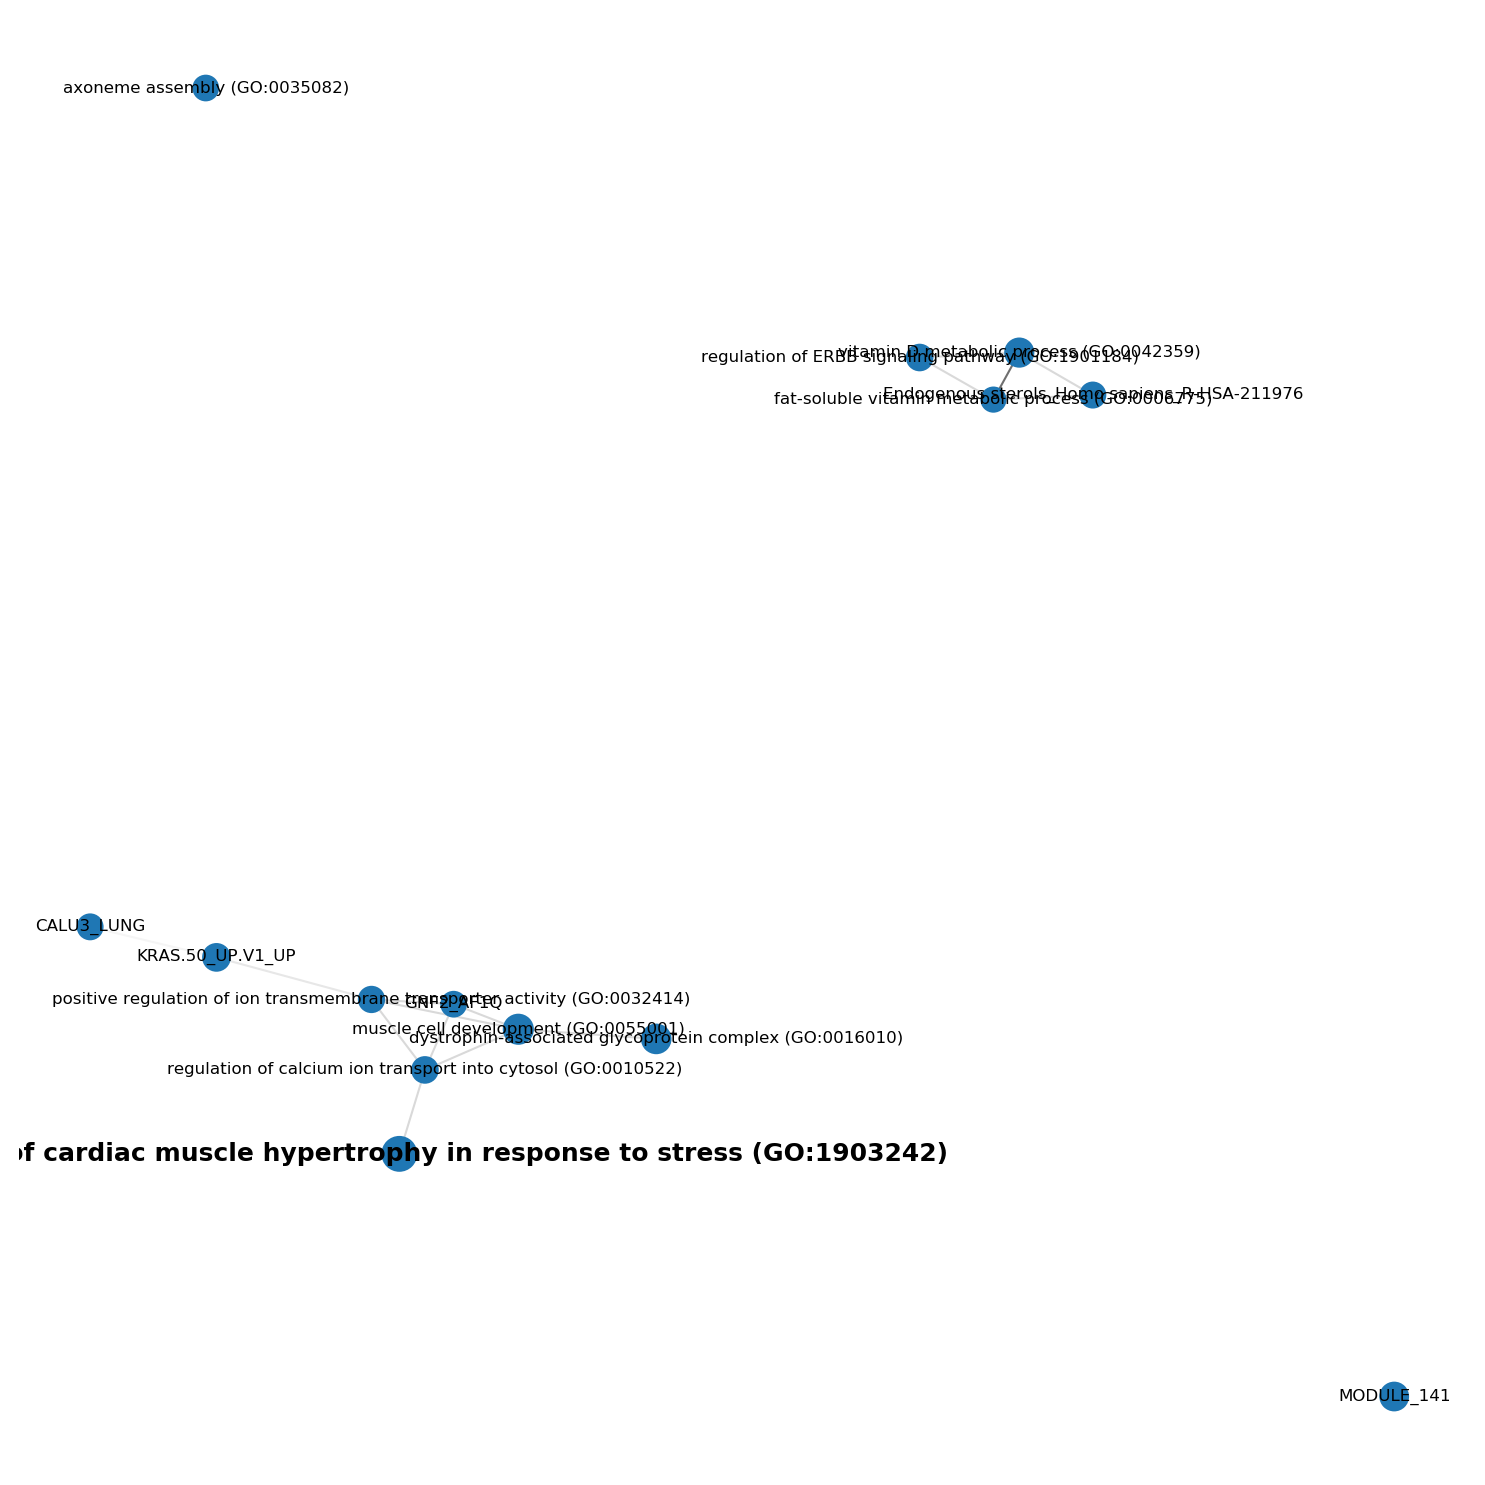

In [74]:
G_gs = erl.make_graph_n(genes_mut_tf_prom,enr_genes_mut_tf_prom, kappa=0.2)

erl.draw_graph(G_gs, spring=100)

Text(0.5,1,'Genes for UP enhancers with TF mutations')

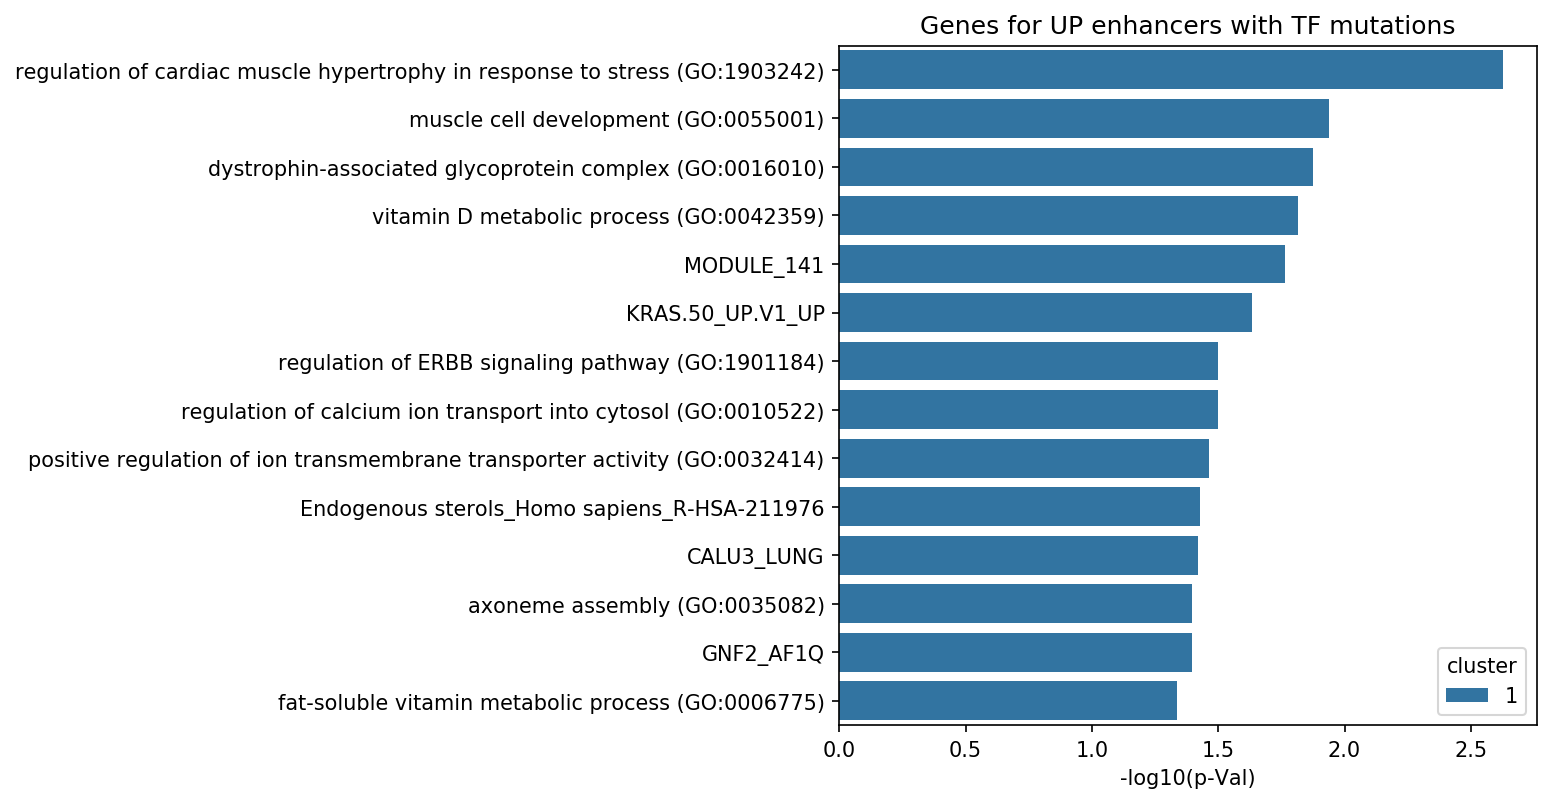

In [76]:
enr_genes_mut_tf_prom.sort_values('cluster', axis=0, inplace = True)
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_genes_mut_tf_prom.head(20)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('Genes for UP enhancers with TF mutations')